In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import numpy as np 
from scipy import signal 
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

2024-01-11 13:51:31.105758: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-11 13:51:31.151678: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-11 13:51:31.151710: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-11 13:51:31.151732: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-11 13:51:31.163088: I tensorflow/core/platform/cpu_feature_g

In [2]:
x=np.load('../BraiNeoCare/Datasets/GAT/zenodo_data_consensus_GAT.npy', mmap_mode='r')
y=np.load('../BraiNeoCare/Datasets/GAT/zenodo_labels_consensus_GAT.npy', mmap_mode='r')


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [3]:
x1=np.load("../BraiNeoCare/Datasets/GAT/zenodo_data_non_GAT.npy", mmap_mode='r')
y1=np.load("../BraiNeoCare/Datasets/GAT/zenodo_labels_non_GAT.npy", mmap_mode='r')


In [4]:
mean=x_train.mean()
std=x_train.std()
x_train=(x_train-mean)/std
x_test=(x_test-mean)/std
x1=(x1-mean)/std

x_train=np.expand_dims(x_train,axis=-1)
x_test=np.expand_dims(x_test,axis=-1)
x1=np.expand_dims(x1,axis=-1)

In [15]:
y_train=y_train.astype(np.float32)
y_test=y_test.astype(np.float32)

In [5]:
channel_names=["Fp1-T3","T3-O1","Fp1-C3","C3-O1","Fp2-C4","C4-O2","Fp2-T4","T4-O2","T3-C3","C3-Cz","Cz-C4","C4-T4"]
indices =[[r,i] for r,c1 in enumerate(channel_names) for i,c2 in enumerate(channel_names) if (c1.split("-")[0]==c2.split("-")[1] or c1.split("-")[1]==c2.split("-")[1] 
          or c1.split("-")[0]==c2.split("-")[0] or c1.split("-")[1]==c2.split("-")[0])]
adj=np.zeros((12,12))
for i in indices:
    adj[i[0]][i[1]]=1
adj=tf.constant(adj,dtype=tf.float32)

2024-01-11 13:53:15.574912: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14947 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:17:00.0, compute capability: 7.5
2024-01-11 13:53:15.575586: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14946 MB memory:  -> device: 1, name: Quadro RTX 5000, pci bus id: 0000:73:00.0, compute capability: 7.5


In [7]:
class GATLayer(layers.Layer):

    def __init__(self,output_dim):
        super(GATLayer, self).__init__()
        self.output_dim = output_dim
        self.LeakyReLU = layers.LeakyReLU(alpha=0.2)
    
    def build(self, input_shape):
        self.W = self.add_weight(name='W',shape=(input_shape[-1], self.output_dim), initializer='random_normal',trainable=True)
        self.a = self.add_weight(name='a',shape=(2*self.output_dim, 1), initializer='random_normal',trainable=True)
    
    def call(self,input,adj):
        H= tf.matmul(input, self.W)
        h1=tf.tile(tf.expand_dims(H, axis=1), [1,12,1,1])
        h2=tf.tile(tf.expand_dims(H, axis=2), [1,1,12,1])
        result =tf.concat([h1 , h2], axis=-1)
        e=self.LeakyReLU(tf.squeeze(tf.matmul(result, self.a),axis=-1))
        zero_mat=-1e20*tf.zeros_like(e)
        msked_e=tf.where(adj==1,e,zero_mat)
        alpha=tf.nn.softmax(msked_e,axis=-1)
        HPrime=tf.matmul(alpha,H)
        return tf.nn.elu(HPrime)


Input= keras.Input(shape=(12,384,1))

x= layers.Conv2D(32,(1,3),activation='relu',padding='same')(Input)
y= layers.Conv2D(32,(1,5),activation='relu',padding='same')(Input)
x= layers.add([x,y])
x= layers.MaxPooling2D((1,2))(x)
x= layers.BatchNormalization()(x)
x= layers.SpatialDropout2D(0.2)(x)

x= layers.Conv2D(64,(1,3),activation='relu',padding='same')(x)
y= layers.Conv2D(64,(1,5),activation='relu',padding='same')(x)
x= layers.add([x,y])
x= layers.MaxPooling2D((1,2))(x)
x= layers.BatchNormalization()(x)
x= layers.SpatialDropout2D(0.2)(x)

x= layers.Conv2D(8,(1,3),activation='relu',padding='same')(x)
y= layers.Conv2D(8,(1,5),activation='relu',padding='same')(x)
x= layers.add([x,y])
x= layers.MaxPooling2D((1,2))(x)
x= layers.BatchNormalization()(x)
x= layers.SpatialDropout2D(0.2)(x)

x= layers.Conv2D(1,(1,3),activation='relu',padding='same')(x)
y= layers.Conv2D(1,(1,5),activation='relu',padding='same')(x)
x= layers.add([x,y])
x= layers.MaxPooling2D((1,2))(x)
x= layers.Reshape((12,24))(x)

x= GATLayer(37)(x,adj)
x= GATLayer(32)(x,adj)
x= GATLayer(16)(x,adj)

x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.2)(x)
x= layers.Dense(32,activation='relu')(x)
x= layers.Dropout(0.2)(x)
x = layers.Dense(16,activation='relu')(x)
x = layers.Dense(1,activation='sigmoid')(x)

model = keras.Model(inputs=Input, outputs=x)

In [8]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 12, 384, 1)]         0         []                            
                                                                                                  
 conv2d_8 (Conv2D)           (None, 12, 384, 32)          128       ['input_2[0][0]']             
                                                                                                  
 conv2d_9 (Conv2D)           (None, 12, 384, 32)          192       ['input_2[0][0]']             
                                                                                                  
 add_4 (Add)                 (None, 12, 384, 32)          0         ['conv2d_8[0][0]',            
                                                                     'conv2d_9[0][0]']      

In [9]:
optimizer=keras.optimizers.Adam(learning_rate=0.002,weight_decay=0.0025)
loss=keras.losses.BinaryFocalCrossentropy(from_logits=False,gamma=2,alpha=0.4,apply_class_balancing=True)
# loss=keras.losses.BinaryCrossentropy(from_logits=False)  
# F1=keras.metrics.F1Score(threshold=0.5, name='F1') 
precision = keras.metrics.Precision()
recall = keras.metrics.Recall()
AUROC = keras.metrics.AUC(curve='ROC', name = 'AUROC')
AUPRC = keras.metrics.AUC(curve='PR', name = 'AUPRC')
model.compile(optimizer=optimizer,loss=loss,metrics=['accuracy', AUROC, AUPRC, precision, recall])    

In [10]:
checkpoint_path = "GAT_model_2/cp_{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path) 
cp_callback=keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_weights_only=False,verbose=0,save_best_only=True,monitor='val_accuracy')  
history=model.fit(x_train,y_train,epochs=200,batch_size=512,verbose=1,validation_data=(x_test,y_test),callbacks=[cp_callback])

Epoch 1/200


2024-01-11 13:53:58.325229: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/spatial_dropout2d_3/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-01-11 13:53:58.948233: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2024-01-11 13:54:02.441794: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fda6c237770 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-11 13:54:02.441830: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Quadro RTX 5000, Compute Capability 7.5
2024-01-11 13:54:02.441839: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): Quadro RTX 5000, Compute Capability 7.5
2024-01-11 13:54:02.450293: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash repr

203/203 [==============================] - ETA: 0s - loss: 0.0671 - accuracy: 0.7048 - AUROC: 0.7536 - AUPRC: 0.6234 - precision: 0.8633 - recall: 0.1279INFO:tensorflow:Assets written to: GAT_model_2/cp_0001.ckpt/assets


INFO:tensorflow:Assets written to: GAT_model_2/cp_0001.ckpt/assets


203/203 [==============================] - 53s 206ms/step - loss: 0.0671 - accuracy: 0.7048 - AUROC: 0.7536 - AUPRC: 0.6234 - precision: 0.8633 - recall: 0.1279 - val_loss: 0.0832 - val_accuracy: 0.7534 - val_AUROC: 0.7171 - val_AUPRC: 0.6674 - val_precision: 0.9467 - val_recall: 0.2572
Epoch 2/200
202/203 [============================>.] - ETA: 0s - loss: 0.0476 - accuracy: 0.8536 - AUROC: 0.8841 - AUPRC: 0.8400 - precision: 0.9085 - recall: 0.6198INFO:tensorflow:Assets written to: GAT_model_2/cp_0002.ckpt/assets


INFO:tensorflow:Assets written to: GAT_model_2/cp_0002.ckpt/assets


203/203 [==============================] - 39s 194ms/step - loss: 0.0476 - accuracy: 0.8536 - AUROC: 0.8841 - AUPRC: 0.8400 - precision: 0.9085 - recall: 0.6198 - val_loss: 0.0558 - val_accuracy: 0.7851 - val_AUROC: 0.8834 - val_AUPRC: 0.8608 - val_precision: 0.9815 - val_recall: 0.3466
Epoch 3/200
202/203 [============================>.] - ETA: 0s - loss: 0.0417 - accuracy: 0.8741 - AUROC: 0.9007 - AUPRC: 0.8728 - precision: 0.9323 - recall: 0.6680INFO:tensorflow:Assets written to: GAT_model_2/cp_0003.ckpt/assets


INFO:tensorflow:Assets written to: GAT_model_2/cp_0003.ckpt/assets


203/203 [==============================] - 62s 307ms/step - loss: 0.0417 - accuracy: 0.8741 - AUROC: 0.9007 - AUPRC: 0.8728 - precision: 0.9323 - recall: 0.6680 - val_loss: 0.0419 - val_accuracy: 0.8661 - val_AUROC: 0.8912 - val_AUPRC: 0.8762 - val_precision: 0.9625 - val_recall: 0.6127
Epoch 4/200
202/203 [============================>.] - ETA: 0s - loss: 0.0395 - accuracy: 0.8841 - AUROC: 0.9098 - AUPRC: 0.8857 - precision: 0.9332 - recall: 0.6999INFO:tensorflow:Assets written to: GAT_model_2/cp_0004.ckpt/assets


INFO:tensorflow:Assets written to: GAT_model_2/cp_0004.ckpt/assets


203/203 [==============================] - 141s 695ms/step - loss: 0.0395 - accuracy: 0.8841 - AUROC: 0.9098 - AUPRC: 0.8857 - precision: 0.9332 - recall: 0.6999 - val_loss: 0.0415 - val_accuracy: 0.8690 - val_AUROC: 0.8971 - val_AUPRC: 0.8833 - val_precision: 0.9703 - val_recall: 0.6167
Epoch 5/200
202/203 [============================>.] - ETA: 0s - loss: 0.0388 - accuracy: 0.8873 - AUROC: 0.9117 - AUPRC: 0.8898 - precision: 0.9340 - recall: 0.7096INFO:tensorflow:Assets written to: GAT_model_2/cp_0005.ckpt/assets


INFO:tensorflow:Assets written to: GAT_model_2/cp_0005.ckpt/assets


203/203 [==============================] - 39s 194ms/step - loss: 0.0389 - accuracy: 0.8873 - AUROC: 0.9117 - AUPRC: 0.8898 - precision: 0.9340 - recall: 0.7095 - val_loss: 0.0392 - val_accuracy: 0.8851 - val_AUROC: 0.9044 - val_AUPRC: 0.8902 - val_precision: 0.9645 - val_recall: 0.6719
Epoch 6/200
202/203 [============================>.] - ETA: 0s - loss: 0.0379 - accuracy: 0.8895 - AUROC: 0.9171 - AUPRC: 0.8951 - precision: 0.9292 - recall: 0.7211INFO:tensorflow:Assets written to: GAT_model_2/cp_0006.ckpt/assets


INFO:tensorflow:Assets written to: GAT_model_2/cp_0006.ckpt/assets


203/203 [==============================] - 39s 194ms/step - loss: 0.0379 - accuracy: 0.8895 - AUROC: 0.9171 - AUPRC: 0.8951 - precision: 0.9291 - recall: 0.7210 - val_loss: 0.0431 - val_accuracy: 0.8916 - val_AUROC: 0.9002 - val_AUPRC: 0.8852 - val_precision: 0.9246 - val_recall: 0.7263
Epoch 7/200
203/203 [==============================] - 37s 182ms/step - loss: 0.0370 - accuracy: 0.8938 - AUROC: 0.9200 - AUPRC: 0.8991 - precision: 0.9329 - recall: 0.7316 - val_loss: 0.0366 - val_accuracy: 0.8883 - val_AUROC: 0.9368 - val_AUPRC: 0.9194 - val_precision: 0.9748 - val_recall: 0.6745
Epoch 8/200
203/203 [==============================] - 37s 181ms/step - loss: 0.0359 - accuracy: 0.8970 - AUROC: 0.9249 - AUPRC: 0.9058 - precision: 0.9354 - recall: 0.7397 - val_loss: 0.0382 - val_accuracy: 0.8789 - val_AUROC: 0.9218 - val_AUPRC: 0.9080 - val_precision: 0.9795 - val_recall: 0.6417
Epoch 9/200
202/203 [============================>.] - ETA: 0s - loss: 0.0351 - accuracy: 0.8977 - AUROC: 0.9293

INFO:tensorflow:Assets written to: GAT_model_2/cp_0009.ckpt/assets


203/203 [==============================] - 40s 196ms/step - loss: 0.0351 - accuracy: 0.8977 - AUROC: 0.9293 - AUPRC: 0.9103 - precision: 0.9349 - recall: 0.7425 - val_loss: 0.0361 - val_accuracy: 0.8940 - val_AUROC: 0.9414 - val_AUPRC: 0.9235 - val_precision: 0.9721 - val_recall: 0.6946
Epoch 10/200
202/203 [============================>.] - ETA: 0s - loss: 0.0349 - accuracy: 0.8991 - AUROC: 0.9294 - AUPRC: 0.9113 - precision: 0.9334 - recall: 0.7485INFO:tensorflow:Assets written to: GAT_model_2/cp_0010.ckpt/assets


INFO:tensorflow:Assets written to: GAT_model_2/cp_0010.ckpt/assets


203/203 [==============================] - 39s 194ms/step - loss: 0.0348 - accuracy: 0.8992 - AUROC: 0.9295 - AUPRC: 0.9113 - precision: 0.9334 - recall: 0.7486 - val_loss: 0.0333 - val_accuracy: 0.8987 - val_AUROC: 0.9476 - val_AUPRC: 0.9309 - val_precision: 0.9728 - val_recall: 0.7087
Epoch 11/200
202/203 [============================>.] - ETA: 0s - loss: 0.0339 - accuracy: 0.9019 - AUROC: 0.9338 - AUPRC: 0.9159 - precision: 0.9382 - recall: 0.7530INFO:tensorflow:Assets written to: GAT_model_2/cp_0011.ckpt/assets


INFO:tensorflow:Assets written to: GAT_model_2/cp_0011.ckpt/assets


203/203 [==============================] - 40s 195ms/step - loss: 0.0339 - accuracy: 0.9019 - AUROC: 0.9339 - AUPRC: 0.9159 - precision: 0.9382 - recall: 0.7530 - val_loss: 0.0337 - val_accuracy: 0.9044 - val_AUROC: 0.9456 - val_AUPRC: 0.9282 - val_precision: 0.9630 - val_recall: 0.7347
Epoch 12/200
202/203 [============================>.] - ETA: 0s - loss: 0.0334 - accuracy: 0.9025 - AUROC: 0.9371 - AUPRC: 0.9186 - precision: 0.9381 - recall: 0.7551INFO:tensorflow:Assets written to: GAT_model_2/cp_0012.ckpt/assets


INFO:tensorflow:Assets written to: GAT_model_2/cp_0012.ckpt/assets


203/203 [==============================] - 39s 194ms/step - loss: 0.0334 - accuracy: 0.9025 - AUROC: 0.9371 - AUPRC: 0.9186 - precision: 0.9381 - recall: 0.7551 - val_loss: 0.0315 - val_accuracy: 0.9157 - val_AUROC: 0.9496 - val_AUPRC: 0.9327 - val_precision: 0.9450 - val_recall: 0.7870
Epoch 13/200
202/203 [============================>.] - ETA: 0s - loss: 0.0329 - accuracy: 0.9042 - AUROC: 0.9385 - AUPRC: 0.9205 - precision: 0.9408 - recall: 0.7583INFO:tensorflow:Assets written to: GAT_model_2/cp_0013.ckpt/assets


INFO:tensorflow:Assets written to: GAT_model_2/cp_0013.ckpt/assets


203/203 [==============================] - 39s 194ms/step - loss: 0.0329 - accuracy: 0.9042 - AUROC: 0.9385 - AUPRC: 0.9204 - precision: 0.9408 - recall: 0.7582 - val_loss: 0.0329 - val_accuracy: 0.9172 - val_AUROC: 0.9531 - val_AUPRC: 0.9366 - val_precision: 0.9364 - val_recall: 0.8002
Epoch 14/200
203/203 [==============================] - 36s 179ms/step - loss: 0.0324 - accuracy: 0.9058 - AUROC: 0.9416 - AUPRC: 0.9237 - precision: 0.9392 - recall: 0.7648 - val_loss: 0.0320 - val_accuracy: 0.9109 - val_AUROC: 0.9514 - val_AUPRC: 0.9343 - val_precision: 0.9575 - val_recall: 0.7602
Epoch 15/200
203/203 [==============================] - 37s 180ms/step - loss: 0.0319 - accuracy: 0.9070 - AUROC: 0.9436 - AUPRC: 0.9265 - precision: 0.9392 - recall: 0.7686 - val_loss: 0.0355 - val_accuracy: 0.8833 - val_AUROC: 0.9456 - val_AUPRC: 0.9293 - val_precision: 0.9806 - val_recall: 0.6546
Epoch 16/200
202/203 [============================>.] - ETA: 0s - loss: 0.0317 - accuracy: 0.9069 - AUROC: 0.9

INFO:tensorflow:Assets written to: GAT_model_2/cp_0016.ckpt/assets


203/203 [==============================] - 39s 193ms/step - loss: 0.0317 - accuracy: 0.9069 - AUROC: 0.9441 - AUPRC: 0.9268 - precision: 0.9417 - recall: 0.7660 - val_loss: 0.0309 - val_accuracy: 0.9183 - val_AUROC: 0.9485 - val_AUPRC: 0.9344 - val_precision: 0.9452 - val_recall: 0.7951
Epoch 17/200
203/203 [==============================] - 36s 179ms/step - loss: 0.0316 - accuracy: 0.9081 - AUROC: 0.9447 - AUPRC: 0.9278 - precision: 0.9388 - recall: 0.7727 - val_loss: 0.0319 - val_accuracy: 0.9111 - val_AUROC: 0.9547 - val_AUPRC: 0.9385 - val_precision: 0.9630 - val_recall: 0.7561
Epoch 18/200
202/203 [============================>.] - ETA: 0s - loss: 0.0308 - accuracy: 0.9107 - AUROC: 0.9476 - AUPRC: 0.9308 - precision: 0.9420 - recall: 0.7780INFO:tensorflow:Assets written to: GAT_model_2/cp_0018.ckpt/assets


INFO:tensorflow:Assets written to: GAT_model_2/cp_0018.ckpt/assets


203/203 [==============================] - 145s 717ms/step - loss: 0.0308 - accuracy: 0.9107 - AUROC: 0.9476 - AUPRC: 0.9309 - precision: 0.9421 - recall: 0.7781 - val_loss: 0.0299 - val_accuracy: 0.9205 - val_AUROC: 0.9586 - val_AUPRC: 0.9438 - val_precision: 0.9484 - val_recall: 0.7995
Epoch 19/200
202/203 [============================>.] - ETA: 0s - loss: 0.0306 - accuracy: 0.9109 - AUROC: 0.9484 - AUPRC: 0.9322 - precision: 0.9427 - recall: 0.7780INFO:tensorflow:Assets written to: GAT_model_2/cp_0019.ckpt/assets


INFO:tensorflow:Assets written to: GAT_model_2/cp_0019.ckpt/assets


203/203 [==============================] - 39s 192ms/step - loss: 0.0306 - accuracy: 0.9109 - AUROC: 0.9484 - AUPRC: 0.9322 - precision: 0.9427 - recall: 0.7780 - val_loss: 0.0314 - val_accuracy: 0.9227 - val_AUROC: 0.9601 - val_AUPRC: 0.9449 - val_precision: 0.9391 - val_recall: 0.8155
Epoch 20/200
203/203 [==============================] - 36s 179ms/step - loss: 0.0302 - accuracy: 0.9117 - AUROC: 0.9501 - AUPRC: 0.9338 - precision: 0.9445 - recall: 0.7790 - val_loss: 0.0343 - val_accuracy: 0.9214 - val_AUROC: 0.9583 - val_AUPRC: 0.9431 - val_precision: 0.9044 - val_recall: 0.8483
Epoch 21/200
203/203 [==============================] - 36s 179ms/step - loss: 0.0303 - accuracy: 0.9130 - AUROC: 0.9499 - AUPRC: 0.9334 - precision: 0.9389 - recall: 0.7885 - val_loss: 0.0306 - val_accuracy: 0.9185 - val_AUROC: 0.9549 - val_AUPRC: 0.9386 - val_precision: 0.9518 - val_recall: 0.7897
Epoch 22/200
202/203 [============================>.] - ETA: 0s - loss: 0.0298 - accuracy: 0.9143 - AUROC: 0.9

INFO:tensorflow:Assets written to: GAT_model_2/cp_0022.ckpt/assets


203/203 [==============================] - 39s 194ms/step - loss: 0.0298 - accuracy: 0.9143 - AUROC: 0.9516 - AUPRC: 0.9353 - precision: 0.9431 - recall: 0.7885 - val_loss: 0.0299 - val_accuracy: 0.9230 - val_AUROC: 0.9615 - val_AUPRC: 0.9469 - val_precision: 0.9578 - val_recall: 0.7986
Epoch 23/200
202/203 [============================>.] - ETA: 0s - loss: 0.0295 - accuracy: 0.9150 - AUROC: 0.9523 - AUPRC: 0.9366 - precision: 0.9401 - recall: 0.7938INFO:tensorflow:Assets written to: GAT_model_2/cp_0023.ckpt/assets


INFO:tensorflow:Assets written to: GAT_model_2/cp_0023.ckpt/assets


203/203 [==============================] - 39s 193ms/step - loss: 0.0295 - accuracy: 0.9150 - AUROC: 0.9523 - AUPRC: 0.9366 - precision: 0.9401 - recall: 0.7938 - val_loss: 0.0303 - val_accuracy: 0.9250 - val_AUROC: 0.9609 - val_AUPRC: 0.9463 - val_precision: 0.9316 - val_recall: 0.8308
Epoch 24/200
203/203 [==============================] - 36s 179ms/step - loss: 0.0294 - accuracy: 0.9149 - AUROC: 0.9530 - AUPRC: 0.9377 - precision: 0.9410 - recall: 0.7923 - val_loss: 0.0361 - val_accuracy: 0.9200 - val_AUROC: 0.9612 - val_AUPRC: 0.9461 - val_precision: 0.8838 - val_recall: 0.8686
Epoch 25/200
203/203 [==============================] - 36s 179ms/step - loss: 0.0291 - accuracy: 0.9148 - AUROC: 0.9545 - AUPRC: 0.9385 - precision: 0.9410 - recall: 0.7923 - val_loss: 0.0307 - val_accuracy: 0.9246 - val_AUROC: 0.9587 - val_AUPRC: 0.9435 - val_precision: 0.9248 - val_recall: 0.8365
Epoch 26/200
203/203 [==============================] - 36s 179ms/step - loss: 0.0289 - accuracy: 0.9168 - AUR

INFO:tensorflow:Assets written to: GAT_model_2/cp_0027.ckpt/assets


203/203 [==============================] - 39s 193ms/step - loss: 0.0286 - accuracy: 0.9169 - AUROC: 0.9557 - AUPRC: 0.9403 - precision: 0.9454 - recall: 0.7946 - val_loss: 0.0304 - val_accuracy: 0.9253 - val_AUROC: 0.9612 - val_AUPRC: 0.9467 - val_precision: 0.9260 - val_recall: 0.8376
Epoch 28/200
202/203 [============================>.] - ETA: 0s - loss: 0.0281 - accuracy: 0.9190 - AUROC: 0.9576 - AUPRC: 0.9425 - precision: 0.9417 - recall: 0.8051INFO:tensorflow:Assets written to: GAT_model_2/cp_0028.ckpt/assets


INFO:tensorflow:Assets written to: GAT_model_2/cp_0028.ckpt/assets


203/203 [==============================] - 40s 195ms/step - loss: 0.0281 - accuracy: 0.9190 - AUROC: 0.9576 - AUPRC: 0.9425 - precision: 0.9418 - recall: 0.8050 - val_loss: 0.0291 - val_accuracy: 0.9315 - val_AUROC: 0.9665 - val_AUPRC: 0.9537 - val_precision: 0.9524 - val_recall: 0.8313
Epoch 29/200
203/203 [==============================] - 36s 179ms/step - loss: 0.0288 - accuracy: 0.9165 - AUROC: 0.9552 - AUPRC: 0.9399 - precision: 0.9411 - recall: 0.7977 - val_loss: 0.0310 - val_accuracy: 0.8982 - val_AUROC: 0.9617 - val_AUPRC: 0.9472 - val_precision: 0.9836 - val_recall: 0.6990
Epoch 30/200
203/203 [==============================] - 36s 178ms/step - loss: 0.0279 - accuracy: 0.9183 - AUROC: 0.9583 - AUPRC: 0.9433 - precision: 0.9442 - recall: 0.8003 - val_loss: 0.0269 - val_accuracy: 0.9152 - val_AUROC: 0.9663 - val_AUPRC: 0.9529 - val_precision: 0.9748 - val_recall: 0.7591
Epoch 31/200
203/203 [==============================] - 37s 180ms/step - loss: 0.0279 - accuracy: 0.9189 - AUR

INFO:tensorflow:Assets written to: GAT_model_2/cp_0032.ckpt/assets


203/203 [==============================] - 39s 195ms/step - loss: 0.0275 - accuracy: 0.9216 - AUROC: 0.9591 - AUPRC: 0.9449 - precision: 0.9414 - recall: 0.8137 - val_loss: 0.0263 - val_accuracy: 0.9330 - val_AUROC: 0.9687 - val_AUPRC: 0.9561 - val_precision: 0.9513 - val_recall: 0.8372
Epoch 33/200
203/203 [==============================] - 36s 179ms/step - loss: 0.0267 - accuracy: 0.9233 - AUROC: 0.9617 - AUPRC: 0.9479 - precision: 0.9442 - recall: 0.8166 - val_loss: 0.0258 - val_accuracy: 0.9277 - val_AUROC: 0.9670 - val_AUPRC: 0.9546 - val_precision: 0.9697 - val_recall: 0.8029
Epoch 34/200
202/203 [============================>.] - ETA: 0s - loss: 0.0268 - accuracy: 0.9229 - AUROC: 0.9617 - AUPRC: 0.9476 - precision: 0.9458 - recall: 0.8135INFO:tensorflow:Assets written to: GAT_model_2/cp_0034.ckpt/assets


INFO:tensorflow:Assets written to: GAT_model_2/cp_0034.ckpt/assets


203/203 [==============================] - 39s 193ms/step - loss: 0.0268 - accuracy: 0.9229 - AUROC: 0.9617 - AUPRC: 0.9476 - precision: 0.9458 - recall: 0.8135 - val_loss: 0.0268 - val_accuracy: 0.9336 - val_AUROC: 0.9685 - val_AUPRC: 0.9553 - val_precision: 0.9398 - val_recall: 0.8506
Epoch 35/200
203/203 [==============================] - 36s 180ms/step - loss: 0.0274 - accuracy: 0.9218 - AUROC: 0.9597 - AUPRC: 0.9456 - precision: 0.9400 - recall: 0.8157 - val_loss: 0.0292 - val_accuracy: 0.9285 - val_AUROC: 0.9661 - val_AUPRC: 0.9528 - val_precision: 0.9023 - val_recall: 0.8753
Epoch 36/200
203/203 [==============================] - 36s 179ms/step - loss: 0.0272 - accuracy: 0.9219 - AUROC: 0.9608 - AUPRC: 0.9463 - precision: 0.9394 - recall: 0.8165 - val_loss: 0.0277 - val_accuracy: 0.9165 - val_AUROC: 0.9678 - val_AUPRC: 0.9546 - val_precision: 0.9747 - val_recall: 0.7635
Epoch 37/200
202/203 [============================>.] - ETA: 0s - loss: 0.0267 - accuracy: 0.9235 - AUROC: 0.9

INFO:tensorflow:Assets written to: GAT_model_2/cp_0037.ckpt/assets


203/203 [==============================] - 40s 195ms/step - loss: 0.0267 - accuracy: 0.9235 - AUROC: 0.9621 - AUPRC: 0.9480 - precision: 0.9411 - recall: 0.8201 - val_loss: 0.0250 - val_accuracy: 0.9340 - val_AUROC: 0.9709 - val_AUPRC: 0.9591 - val_precision: 0.9478 - val_recall: 0.8437
Epoch 38/200
203/203 [==============================] - 36s 179ms/step - loss: 0.0270 - accuracy: 0.9224 - AUROC: 0.9606 - AUPRC: 0.9469 - precision: 0.9451 - recall: 0.8126 - val_loss: 0.0303 - val_accuracy: 0.9268 - val_AUROC: 0.9678 - val_AUPRC: 0.9541 - val_precision: 0.8932 - val_recall: 0.8804
Epoch 39/200
202/203 [============================>.] - ETA: 0s - loss: 0.0260 - accuracy: 0.9262 - AUROC: 0.9644 - AUPRC: 0.9508 - precision: 0.9446 - recall: 0.8253INFO:tensorflow:Assets written to: GAT_model_2/cp_0039.ckpt/assets


INFO:tensorflow:Assets written to: GAT_model_2/cp_0039.ckpt/assets


203/203 [==============================] - 39s 193ms/step - loss: 0.0260 - accuracy: 0.9262 - AUROC: 0.9644 - AUPRC: 0.9508 - precision: 0.9446 - recall: 0.8254 - val_loss: 0.0264 - val_accuracy: 0.9355 - val_AUROC: 0.9716 - val_AUPRC: 0.9596 - val_precision: 0.9279 - val_recall: 0.8695
Epoch 40/200
203/203 [==============================] - 36s 179ms/step - loss: 0.0261 - accuracy: 0.9245 - AUROC: 0.9643 - AUPRC: 0.9507 - precision: 0.9417 - recall: 0.8226 - val_loss: 0.0254 - val_accuracy: 0.9259 - val_AUROC: 0.9685 - val_AUPRC: 0.9565 - val_precision: 0.9725 - val_recall: 0.7949
Epoch 41/200
202/203 [============================>.] - ETA: 0s - loss: 0.0260 - accuracy: 0.9253 - AUROC: 0.9639 - AUPRC: 0.9508 - precision: 0.9439 - recall: 0.8232INFO:tensorflow:Assets written to: GAT_model_2/cp_0041.ckpt/assets


INFO:tensorflow:Assets written to: GAT_model_2/cp_0041.ckpt/assets


203/203 [==============================] - 40s 195ms/step - loss: 0.0260 - accuracy: 0.9254 - AUROC: 0.9639 - AUPRC: 0.9508 - precision: 0.9440 - recall: 0.8233 - val_loss: 0.0246 - val_accuracy: 0.9358 - val_AUROC: 0.9714 - val_AUPRC: 0.9600 - val_precision: 0.9635 - val_recall: 0.8346
Epoch 42/200
203/203 [==============================] - 36s 179ms/step - loss: 0.0256 - accuracy: 0.9261 - AUROC: 0.9653 - AUPRC: 0.9519 - precision: 0.9450 - recall: 0.8246 - val_loss: 0.0254 - val_accuracy: 0.9336 - val_AUROC: 0.9701 - val_AUPRC: 0.9585 - val_precision: 0.9535 - val_recall: 0.8370
Epoch 43/200
203/203 [==============================] - 36s 179ms/step - loss: 0.0257 - accuracy: 0.9258 - AUROC: 0.9649 - AUPRC: 0.9516 - precision: 0.9469 - recall: 0.8219 - val_loss: 0.0267 - val_accuracy: 0.9193 - val_AUROC: 0.9693 - val_AUPRC: 0.9572 - val_precision: 0.9803 - val_recall: 0.7675
Epoch 44/200
203/203 [==============================] - 36s 179ms/step - loss: 0.0266 - accuracy: 0.9239 - AUR

INFO:tensorflow:Assets written to: GAT_model_2/cp_0045.ckpt/assets


203/203 [==============================] - 39s 194ms/step - loss: 0.0254 - accuracy: 0.9267 - AUROC: 0.9654 - AUPRC: 0.9530 - precision: 0.9479 - recall: 0.8238 - val_loss: 0.0254 - val_accuracy: 0.9373 - val_AUROC: 0.9728 - val_AUPRC: 0.9615 - val_precision: 0.9231 - val_recall: 0.8808
Epoch 46/200
202/203 [============================>.] - ETA: 0s - loss: 0.0252 - accuracy: 0.9274 - AUROC: 0.9667 - AUPRC: 0.9535 - precision: 0.9460 - recall: 0.8278INFO:tensorflow:Assets written to: GAT_model_2/cp_0046.ckpt/assets


INFO:tensorflow:Assets written to: GAT_model_2/cp_0046.ckpt/assets


203/203 [==============================] - 39s 192ms/step - loss: 0.0252 - accuracy: 0.9274 - AUROC: 0.9667 - AUPRC: 0.9535 - precision: 0.9460 - recall: 0.8278 - val_loss: 0.0256 - val_accuracy: 0.9384 - val_AUROC: 0.9730 - val_AUPRC: 0.9625 - val_precision: 0.9607 - val_recall: 0.8454
Epoch 47/200
203/203 [==============================] - 36s 178ms/step - loss: 0.0255 - accuracy: 0.9259 - AUROC: 0.9656 - AUPRC: 0.9527 - precision: 0.9455 - recall: 0.8236 - val_loss: 0.0237 - val_accuracy: 0.9328 - val_AUROC: 0.9743 - val_AUPRC: 0.9632 - val_precision: 0.9672 - val_recall: 0.8217
Epoch 48/200
203/203 [==============================] - 36s 179ms/step - loss: 0.0249 - accuracy: 0.9295 - AUROC: 0.9673 - AUPRC: 0.9546 - precision: 0.9453 - recall: 0.8352 - val_loss: 0.0243 - val_accuracy: 0.9300 - val_AUROC: 0.9708 - val_AUPRC: 0.9587 - val_precision: 0.9608 - val_recall: 0.8186
Epoch 49/200
203/203 [==============================] - 37s 180ms/step - loss: 0.0250 - accuracy: 0.9280 - AUR

INFO:tensorflow:Assets written to: GAT_model_2/cp_0050.ckpt/assets


203/203 [==============================] - 39s 194ms/step - loss: 0.0247 - accuracy: 0.9286 - AUROC: 0.9681 - AUPRC: 0.9552 - precision: 0.9432 - recall: 0.8342 - val_loss: 0.0246 - val_accuracy: 0.9388 - val_AUROC: 0.9732 - val_AUPRC: 0.9617 - val_precision: 0.9339 - val_recall: 0.8739
Epoch 51/200
202/203 [============================>.] - ETA: 0s - loss: 0.0245 - accuracy: 0.9293 - AUROC: 0.9687 - AUPRC: 0.9559 - precision: 0.9462 - recall: 0.8338INFO:tensorflow:Assets written to: GAT_model_2/cp_0051.ckpt/assets


INFO:tensorflow:Assets written to: GAT_model_2/cp_0051.ckpt/assets


203/203 [==============================] - 39s 194ms/step - loss: 0.0245 - accuracy: 0.9293 - AUROC: 0.9687 - AUPRC: 0.9560 - precision: 0.9462 - recall: 0.8337 - val_loss: 0.0236 - val_accuracy: 0.9396 - val_AUROC: 0.9741 - val_AUPRC: 0.9630 - val_precision: 0.9523 - val_recall: 0.8575
Epoch 52/200
203/203 [==============================] - 36s 179ms/step - loss: 0.0243 - accuracy: 0.9296 - AUROC: 0.9687 - AUPRC: 0.9566 - precision: 0.9477 - recall: 0.8333 - val_loss: 0.0244 - val_accuracy: 0.9323 - val_AUROC: 0.9707 - val_AUPRC: 0.9586 - val_precision: 0.9500 - val_recall: 0.8361
Epoch 53/200
203/203 [==============================] - 36s 179ms/step - loss: 0.0244 - accuracy: 0.9302 - AUROC: 0.9689 - AUPRC: 0.9564 - precision: 0.9467 - recall: 0.8361 - val_loss: 0.0225 - val_accuracy: 0.9394 - val_AUROC: 0.9761 - val_AUPRC: 0.9652 - val_precision: 0.9599 - val_recall: 0.8494
Epoch 54/200
203/203 [==============================] - 36s 180ms/step - loss: 0.0244 - accuracy: 0.9303 - AUR

INFO:tensorflow:Assets written to: GAT_model_2/cp_0058.ckpt/assets


203/203 [==============================] - 39s 192ms/step - loss: 0.0239 - accuracy: 0.9317 - AUROC: 0.9701 - AUPRC: 0.9581 - precision: 0.9472 - recall: 0.8406 - val_loss: 0.0231 - val_accuracy: 0.9399 - val_AUROC: 0.9772 - val_AUPRC: 0.9667 - val_precision: 0.9639 - val_recall: 0.8471
Epoch 59/200
202/203 [============================>.] - ETA: 0s - loss: 0.0239 - accuracy: 0.9317 - AUROC: 0.9705 - AUPRC: 0.9580 - precision: 0.9462 - recall: 0.8414INFO:tensorflow:Assets written to: GAT_model_2/cp_0059.ckpt/assets


INFO:tensorflow:Assets written to: GAT_model_2/cp_0059.ckpt/assets


203/203 [==============================] - 39s 193ms/step - loss: 0.0239 - accuracy: 0.9317 - AUROC: 0.9705 - AUPRC: 0.9580 - precision: 0.9462 - recall: 0.8414 - val_loss: 0.0223 - val_accuracy: 0.9429 - val_AUROC: 0.9779 - val_AUPRC: 0.9674 - val_precision: 0.9567 - val_recall: 0.8638
Epoch 60/200
203/203 [==============================] - 36s 178ms/step - loss: 0.0237 - accuracy: 0.9312 - AUROC: 0.9712 - AUPRC: 0.9589 - precision: 0.9487 - recall: 0.8372 - val_loss: 0.0242 - val_accuracy: 0.9403 - val_AUROC: 0.9756 - val_AUPRC: 0.9646 - val_precision: 0.9417 - val_recall: 0.8705
Epoch 61/200
203/203 [==============================] - 36s 179ms/step - loss: 0.0232 - accuracy: 0.9320 - AUROC: 0.9723 - AUPRC: 0.9604 - precision: 0.9494 - recall: 0.8392 - val_loss: 0.0246 - val_accuracy: 0.9277 - val_AUROC: 0.9712 - val_AUPRC: 0.9576 - val_precision: 0.9627 - val_recall: 0.8093
Epoch 62/200
203/203 [==============================] - 36s 179ms/step - loss: 0.0233 - accuracy: 0.9326 - AUR

INFO:tensorflow:Assets written to: GAT_model_2/cp_0065.ckpt/assets


203/203 [==============================] - 39s 194ms/step - loss: 0.0231 - accuracy: 0.9329 - AUROC: 0.9728 - AUPRC: 0.9607 - precision: 0.9480 - recall: 0.8436 - val_loss: 0.0216 - val_accuracy: 0.9443 - val_AUROC: 0.9802 - val_AUPRC: 0.9705 - val_precision: 0.9627 - val_recall: 0.8623
Epoch 66/200
203/203 [==============================] - 36s 178ms/step - loss: 0.0231 - accuracy: 0.9334 - AUROC: 0.9724 - AUPRC: 0.9603 - precision: 0.9506 - recall: 0.8425 - val_loss: 0.0229 - val_accuracy: 0.9348 - val_AUROC: 0.9767 - val_AUPRC: 0.9666 - val_precision: 0.9741 - val_recall: 0.8215
Epoch 67/200
203/203 [==============================] - 36s 180ms/step - loss: 0.0228 - accuracy: 0.9338 - AUROC: 0.9731 - AUPRC: 0.9616 - precision: 0.9500 - recall: 0.8442 - val_loss: 0.0249 - val_accuracy: 0.9407 - val_AUROC: 0.9771 - val_AUPRC: 0.9664 - val_precision: 0.9243 - val_recall: 0.8908
Epoch 68/200
202/203 [============================>.] - ETA: 0s - loss: 0.0235 - accuracy: 0.9312 - AUROC: 0.9

INFO:tensorflow:Assets written to: GAT_model_2/cp_0068.ckpt/assets


203/203 [==============================] - 39s 193ms/step - loss: 0.0235 - accuracy: 0.9312 - AUROC: 0.9719 - AUPRC: 0.9595 - precision: 0.9459 - recall: 0.8401 - val_loss: 0.0210 - val_accuracy: 0.9463 - val_AUROC: 0.9811 - val_AUPRC: 0.9713 - val_precision: 0.9539 - val_recall: 0.8775
Epoch 69/200
203/203 [==============================] - 36s 179ms/step - loss: 0.0226 - accuracy: 0.9342 - AUROC: 0.9737 - AUPRC: 0.9623 - precision: 0.9459 - recall: 0.8497 - val_loss: 0.0223 - val_accuracy: 0.9313 - val_AUROC: 0.9793 - val_AUPRC: 0.9693 - val_precision: 0.9798 - val_recall: 0.8056
Epoch 70/200
203/203 [==============================] - 36s 179ms/step - loss: 0.0235 - accuracy: 0.9315 - AUROC: 0.9715 - AUPRC: 0.9592 - precision: 0.9493 - recall: 0.8377 - val_loss: 0.0229 - val_accuracy: 0.9461 - val_AUROC: 0.9797 - val_AUPRC: 0.9703 - val_precision: 0.9432 - val_recall: 0.8878
Epoch 71/200
203/203 [==============================] - 37s 180ms/step - loss: 0.0228 - accuracy: 0.9336 - AUR

INFO:tensorflow:Assets written to: GAT_model_2/cp_0079.ckpt/assets


203/203 [==============================] - 39s 194ms/step - loss: 0.0225 - accuracy: 0.9344 - AUROC: 0.9742 - AUPRC: 0.9628 - precision: 0.9530 - recall: 0.8431 - val_loss: 0.0209 - val_accuracy: 0.9480 - val_AUROC: 0.9806 - val_AUPRC: 0.9715 - val_precision: 0.9463 - val_recall: 0.8910
Epoch 80/200
203/203 [==============================] - 36s 179ms/step - loss: 0.0221 - accuracy: 0.9357 - AUROC: 0.9755 - AUPRC: 0.9641 - precision: 0.9499 - recall: 0.8506 - val_loss: 0.0245 - val_accuracy: 0.9443 - val_AUROC: 0.9792 - val_AUPRC: 0.9681 - val_precision: 0.9359 - val_recall: 0.8898
Epoch 81/200
203/203 [==============================] - 36s 180ms/step - loss: 0.0220 - accuracy: 0.9367 - AUROC: 0.9752 - AUPRC: 0.9640 - precision: 0.9523 - recall: 0.8514 - val_loss: 0.0210 - val_accuracy: 0.9427 - val_AUROC: 0.9806 - val_AUPRC: 0.9710 - val_precision: 0.9559 - val_recall: 0.8638
Epoch 82/200
203/203 [==============================] - 36s 179ms/step - loss: 0.0219 - accuracy: 0.9362 - AUR

INFO:tensorflow:Assets written to: GAT_model_2/cp_0087.ckpt/assets


203/203 [==============================] - 39s 193ms/step - loss: 0.0215 - accuracy: 0.9385 - AUROC: 0.9765 - AUPRC: 0.9655 - precision: 0.9487 - recall: 0.8606 - val_loss: 0.0202 - val_accuracy: 0.9518 - val_AUROC: 0.9829 - val_AUPRC: 0.9749 - val_precision: 0.9504 - val_recall: 0.8990
Epoch 88/200
203/203 [==============================] - 36s 178ms/step - loss: 0.0210 - accuracy: 0.9387 - AUROC: 0.9777 - AUPRC: 0.9673 - precision: 0.9519 - recall: 0.8580 - val_loss: 0.0351 - val_accuracy: 0.9147 - val_AUROC: 0.9824 - val_AUPRC: 0.9727 - val_precision: 0.8128 - val_recall: 0.9589
Epoch 89/200
203/203 [==============================] - 36s 178ms/step - loss: 0.0222 - accuracy: 0.9354 - AUROC: 0.9752 - AUPRC: 0.9638 - precision: 0.9505 - recall: 0.8491 - val_loss: 0.0210 - val_accuracy: 0.9454 - val_AUROC: 0.9832 - val_AUPRC: 0.9747 - val_precision: 0.9660 - val_recall: 0.8626
Epoch 90/200
203/203 [==============================] - 36s 179ms/step - loss: 0.0217 - accuracy: 0.9370 - AUR

INFO:tensorflow:Assets written to: GAT_model_2/cp_0097.ckpt/assets


203/203 [==============================] - 39s 192ms/step - loss: 0.0210 - accuracy: 0.9384 - AUROC: 0.9778 - AUPRC: 0.9672 - precision: 0.9516 - recall: 0.8574 - val_loss: 0.0191 - val_accuracy: 0.9520 - val_AUROC: 0.9846 - val_AUPRC: 0.9766 - val_precision: 0.9622 - val_recall: 0.8876
Epoch 98/200
203/203 [==============================] - 36s 178ms/step - loss: 0.0211 - accuracy: 0.9383 - AUROC: 0.9780 - AUPRC: 0.9669 - precision: 0.9518 - recall: 0.8570 - val_loss: 0.0222 - val_accuracy: 0.9488 - val_AUROC: 0.9819 - val_AUPRC: 0.9737 - val_precision: 0.9314 - val_recall: 0.9098
Epoch 99/200
203/203 [==============================] - 36s 178ms/step - loss: 0.0212 - accuracy: 0.9373 - AUROC: 0.9774 - AUPRC: 0.9666 - precision: 0.9522 - recall: 0.8534 - val_loss: 0.0209 - val_accuracy: 0.9507 - val_AUROC: 0.9841 - val_AUPRC: 0.9748 - val_precision: 0.9614 - val_recall: 0.8841
Epoch 100/200
203/203 [==============================] - 36s 178ms/step - loss: 0.0208 - accuracy: 0.9391 - AU

INFO:tensorflow:Assets written to: GAT_model_2/cp_0103.ckpt/assets


203/203 [==============================] - 39s 194ms/step - loss: 0.0206 - accuracy: 0.9399 - AUROC: 0.9788 - AUPRC: 0.9681 - precision: 0.9529 - recall: 0.8609 - val_loss: 0.0187 - val_accuracy: 0.9537 - val_AUROC: 0.9859 - val_AUPRC: 0.9785 - val_precision: 0.9574 - val_recall: 0.8976
Epoch 104/200
203/203 [==============================] - 36s 177ms/step - loss: 0.0214 - accuracy: 0.9368 - AUROC: 0.9769 - AUPRC: 0.9661 - precision: 0.9520 - recall: 0.8520 - val_loss: 0.0187 - val_accuracy: 0.9535 - val_AUROC: 0.9858 - val_AUPRC: 0.9783 - val_precision: 0.9542 - val_recall: 0.9005
Epoch 105/200
203/203 [==============================] - 36s 179ms/step - loss: 0.0211 - accuracy: 0.9387 - AUROC: 0.9777 - AUPRC: 0.9669 - precision: 0.9516 - recall: 0.8586 - val_loss: 0.0193 - val_accuracy: 0.9469 - val_AUROC: 0.9844 - val_AUPRC: 0.9756 - val_precision: 0.9665 - val_recall: 0.8671
Epoch 106/200
203/203 [==============================] - 36s 179ms/step - loss: 0.0209 - accuracy: 0.9395 - 

INFO:tensorflow:Assets written to: GAT_model_2/cp_0115.ckpt/assets


203/203 [==============================] - 39s 193ms/step - loss: 0.0201 - accuracy: 0.9409 - AUROC: 0.9802 - AUPRC: 0.9699 - precision: 0.9512 - recall: 0.8657 - val_loss: 0.0203 - val_accuracy: 0.9547 - val_AUROC: 0.9870 - val_AUPRC: 0.9792 - val_precision: 0.9407 - val_recall: 0.9189
Epoch 116/200
203/203 [==============================] - 36s 178ms/step - loss: 0.0199 - accuracy: 0.9421 - AUROC: 0.9803 - AUPRC: 0.9704 - precision: 0.9540 - recall: 0.8669 - val_loss: 0.0195 - val_accuracy: 0.9513 - val_AUROC: 0.9843 - val_AUPRC: 0.9764 - val_precision: 0.9624 - val_recall: 0.8851
Epoch 117/200
203/203 [==============================] - 36s 179ms/step - loss: 0.0202 - accuracy: 0.9411 - AUROC: 0.9798 - AUPRC: 0.9695 - precision: 0.9523 - recall: 0.8653 - val_loss: 0.0296 - val_accuracy: 0.9331 - val_AUROC: 0.9853 - val_AUPRC: 0.9769 - val_precision: 0.8567 - val_recall: 0.9544
Epoch 118/200
203/203 [==============================] - 36s 178ms/step - loss: 0.0204 - accuracy: 0.9402 - 

INFO:tensorflow:Assets written to: GAT_model_2/cp_0123.ckpt/assets


203/203 [==============================] - 39s 192ms/step - loss: 0.0195 - accuracy: 0.9421 - AUROC: 0.9814 - AUPRC: 0.9719 - precision: 0.9549 - recall: 0.8657 - val_loss: 0.0180 - val_accuracy: 0.9561 - val_AUROC: 0.9873 - val_AUPRC: 0.9796 - val_precision: 0.9625 - val_recall: 0.9003
Epoch 124/200
203/203 [==============================] - 36s 178ms/step - loss: 0.0200 - accuracy: 0.9412 - AUROC: 0.9803 - AUPRC: 0.9701 - precision: 0.9530 - recall: 0.8649 - val_loss: 0.0193 - val_accuracy: 0.9376 - val_AUROC: 0.9853 - val_AUPRC: 0.9772 - val_precision: 0.9812 - val_recall: 0.8243
Epoch 125/200
202/203 [============================>.] - ETA: 0s - loss: 0.0193 - accuracy: 0.9425 - AUROC: 0.9819 - AUPRC: 0.9723 - precision: 0.9535 - recall: 0.8686INFO:tensorflow:Assets written to: GAT_model_2/cp_0125.ckpt/assets


INFO:tensorflow:Assets written to: GAT_model_2/cp_0125.ckpt/assets


203/203 [==============================] - 39s 193ms/step - loss: 0.0193 - accuracy: 0.9425 - AUROC: 0.9819 - AUPRC: 0.9723 - precision: 0.9535 - recall: 0.8686 - val_loss: 0.0187 - val_accuracy: 0.9569 - val_AUROC: 0.9880 - val_AUPRC: 0.9813 - val_precision: 0.9514 - val_recall: 0.9143
Epoch 126/200
203/203 [==============================] - 36s 178ms/step - loss: 0.0195 - accuracy: 0.9426 - AUROC: 0.9814 - AUPRC: 0.9716 - precision: 0.9521 - recall: 0.8702 - val_loss: 0.0184 - val_accuracy: 0.9525 - val_AUROC: 0.9867 - val_AUPRC: 0.9786 - val_precision: 0.9590 - val_recall: 0.8922
Epoch 127/200
203/203 [==============================] - 36s 178ms/step - loss: 0.0192 - accuracy: 0.9436 - AUROC: 0.9820 - AUPRC: 0.9723 - precision: 0.9523 - recall: 0.8734 - val_loss: 0.0176 - val_accuracy: 0.9527 - val_AUROC: 0.9870 - val_AUPRC: 0.9797 - val_precision: 0.9673 - val_recall: 0.8847
Epoch 128/200
203/203 [==============================] - 36s 179ms/step - loss: 0.0196 - accuracy: 0.9419 - 

INFO:tensorflow:Assets written to: GAT_model_2/cp_0141.ckpt/assets


203/203 [==============================] - 39s 193ms/step - loss: 0.0192 - accuracy: 0.9435 - AUROC: 0.9820 - AUPRC: 0.9724 - precision: 0.9515 - recall: 0.8739 - val_loss: 0.0185 - val_accuracy: 0.9601 - val_AUROC: 0.9888 - val_AUPRC: 0.9822 - val_precision: 0.9540 - val_recall: 0.9219
Epoch 142/200
203/203 [==============================] - 36s 178ms/step - loss: 0.0191 - accuracy: 0.9440 - AUROC: 0.9822 - AUPRC: 0.9725 - precision: 0.9536 - recall: 0.8734 - val_loss: 0.0183 - val_accuracy: 0.9542 - val_AUROC: 0.9872 - val_AUPRC: 0.9795 - val_precision: 0.9602 - val_recall: 0.8966
Epoch 143/200
203/203 [==============================] - 36s 178ms/step - loss: 0.0194 - accuracy: 0.9422 - AUROC: 0.9815 - AUPRC: 0.9720 - precision: 0.9534 - recall: 0.8678 - val_loss: 0.0415 - val_accuracy: 0.8898 - val_AUROC: 0.9802 - val_AUPRC: 0.9689 - val_precision: 0.7603 - val_recall: 0.9660
Epoch 144/200
203/203 [==============================] - 36s 179ms/step - loss: 0.0212 - accuracy: 0.9374 - 

INFO:tensorflow:Assets written to: GAT_model_2/cp_0165.ckpt/assets


203/203 [==============================] - 39s 191ms/step - loss: 0.0182 - accuracy: 0.9474 - AUROC: 0.9839 - AUPRC: 0.9753 - precision: 0.9546 - recall: 0.8832 - val_loss: 0.0175 - val_accuracy: 0.9617 - val_AUROC: 0.9901 - val_AUPRC: 0.9844 - val_precision: 0.9434 - val_recall: 0.9387
Epoch 166/200
203/203 [==============================] - 36s 178ms/step - loss: 0.0182 - accuracy: 0.9468 - AUROC: 0.9840 - AUPRC: 0.9751 - precision: 0.9528 - recall: 0.8829 - val_loss: 0.0210 - val_accuracy: 0.9593 - val_AUROC: 0.9900 - val_AUPRC: 0.9841 - val_precision: 0.9312 - val_recall: 0.9448
Epoch 167/200
203/203 [==============================] - 36s 178ms/step - loss: 0.0186 - accuracy: 0.9462 - AUROC: 0.9833 - AUPRC: 0.9742 - precision: 0.9528 - recall: 0.8809 - val_loss: 0.0160 - val_accuracy: 0.9606 - val_AUROC: 0.9901 - val_AUPRC: 0.9845 - val_precision: 0.9613 - val_recall: 0.9161
Epoch 168/200
203/203 [==============================] - 36s 178ms/step - loss: 0.0182 - accuracy: 0.9468 - 

INFO:tensorflow:Assets written to: GAT_model_2/cp_0180.ckpt/assets


203/203 [==============================] - 39s 193ms/step - loss: 0.0179 - accuracy: 0.9474 - AUROC: 0.9845 - AUPRC: 0.9760 - precision: 0.9549 - recall: 0.8826 - val_loss: 0.0184 - val_accuracy: 0.9622 - val_AUROC: 0.9904 - val_AUPRC: 0.9846 - val_precision: 0.9446 - val_recall: 0.9391
Epoch 181/200
203/203 [==============================] - 36s 178ms/step - loss: 0.0176 - accuracy: 0.9477 - AUROC: 0.9853 - AUPRC: 0.9768 - precision: 0.9568 - recall: 0.8815 - val_loss: 0.0204 - val_accuracy: 0.9558 - val_AUROC: 0.9896 - val_AUPRC: 0.9837 - val_precision: 0.9184 - val_recall: 0.9486
Epoch 182/200
202/203 [============================>.] - ETA: 0s - loss: 0.0176 - accuracy: 0.9482 - AUROC: 0.9851 - AUPRC: 0.9768 - precision: 0.9554 - recall: 0.8846INFO:tensorflow:Assets written to: GAT_model_2/cp_0182.ckpt/assets


INFO:tensorflow:Assets written to: GAT_model_2/cp_0182.ckpt/assets


203/203 [==============================] - 39s 193ms/step - loss: 0.0176 - accuracy: 0.9482 - AUROC: 0.9851 - AUPRC: 0.9768 - precision: 0.9554 - recall: 0.8846 - val_loss: 0.0190 - val_accuracy: 0.9624 - val_AUROC: 0.9904 - val_AUPRC: 0.9850 - val_precision: 0.9544 - val_recall: 0.9289
Epoch 183/200
202/203 [============================>.] - ETA: 0s - loss: 0.0180 - accuracy: 0.9471 - AUROC: 0.9845 - AUPRC: 0.9755 - precision: 0.9538 - recall: 0.8831INFO:tensorflow:Assets written to: GAT_model_2/cp_0183.ckpt/assets


INFO:tensorflow:Assets written to: GAT_model_2/cp_0183.ckpt/assets


203/203 [==============================] - 39s 192ms/step - loss: 0.0180 - accuracy: 0.9471 - AUROC: 0.9845 - AUPRC: 0.9755 - precision: 0.9538 - recall: 0.8831 - val_loss: 0.0157 - val_accuracy: 0.9627 - val_AUROC: 0.9909 - val_AUPRC: 0.9855 - val_precision: 0.9660 - val_recall: 0.9177
Epoch 184/200
203/203 [==============================] - 36s 178ms/step - loss: 0.0175 - accuracy: 0.9490 - AUROC: 0.9853 - AUPRC: 0.9770 - precision: 0.9579 - recall: 0.8847 - val_loss: 0.0162 - val_accuracy: 0.9621 - val_AUROC: 0.9910 - val_AUPRC: 0.9855 - val_precision: 0.9671 - val_recall: 0.9146
Epoch 185/200
203/203 [==============================] - 36s 178ms/step - loss: 0.0180 - accuracy: 0.9465 - AUROC: 0.9844 - AUPRC: 0.9756 - precision: 0.9556 - recall: 0.8793 - val_loss: 0.0164 - val_accuracy: 0.9528 - val_AUROC: 0.9887 - val_AUPRC: 0.9820 - val_precision: 0.9739 - val_recall: 0.8785
Epoch 186/200
203/203 [==============================] - 36s 179ms/step - loss: 0.0188 - accuracy: 0.9453 - 

INFO:tensorflow:Assets written to: GAT_model_2/cp_0190.ckpt/assets


203/203 [==============================] - 39s 193ms/step - loss: 0.0175 - accuracy: 0.9483 - AUROC: 0.9853 - AUPRC: 0.9767 - precision: 0.9540 - recall: 0.8865 - val_loss: 0.0179 - val_accuracy: 0.9631 - val_AUROC: 0.9904 - val_AUPRC: 0.9848 - val_precision: 0.9515 - val_recall: 0.9345
Epoch 191/200
203/203 [==============================] - 36s 177ms/step - loss: 0.0172 - accuracy: 0.9491 - AUROC: 0.9858 - AUPRC: 0.9776 - precision: 0.9550 - recall: 0.8880 - val_loss: 0.0158 - val_accuracy: 0.9589 - val_AUROC: 0.9909 - val_AUPRC: 0.9856 - val_precision: 0.9757 - val_recall: 0.8960
Epoch 192/200
203/203 [==============================] - 36s 179ms/step - loss: 0.0176 - accuracy: 0.9481 - AUROC: 0.9851 - AUPRC: 0.9767 - precision: 0.9585 - recall: 0.8812 - val_loss: 0.0152 - val_accuracy: 0.9614 - val_AUROC: 0.9908 - val_AUPRC: 0.9850 - val_precision: 0.9619 - val_recall: 0.9178
Epoch 193/200
203/203 [==============================] - 36s 178ms/step - loss: 0.0176 - accuracy: 0.9494 - 

In [11]:
with open("history_GAT.jason", 'w') as f:
    pd.DataFrame(history.history).to_json(f)

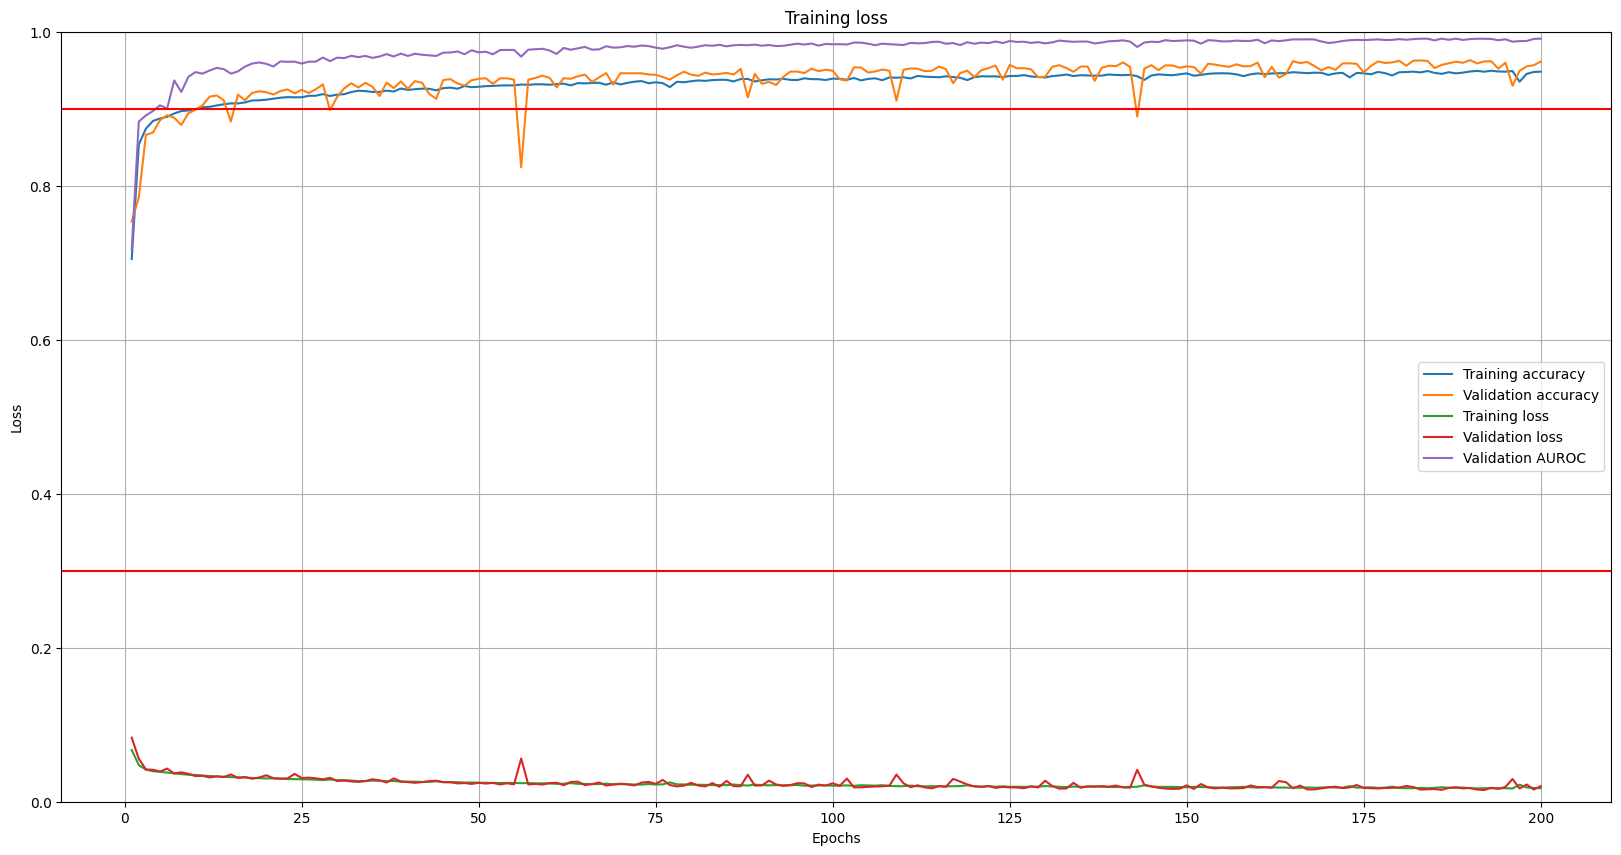

In [13]:
# Plot the training and validation loss and accuracy for each epoch for 4s partitions
with open('history_GAT.jason','r') as f:
    history_1 = pd.read_json(f)

training_accuracy = history_1['accuracy']
val_accuracy=history_1['val_accuracy']
training_loss = history_1['loss']
val_loss=history_1['val_loss']
val_AUROC=history_1['val_AUROC']
val_AUPRC=history_1['val_AUPRC']
val_precision=history_1['val_precision']
epochs = range(1, len(training_accuracy) + 1)

# Plot training loss against epochs
plt.figure(figsize=(20, 10))
plt.plot(epochs, training_accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.plot(epochs, training_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.plot(epochs, val_AUROC, label='Validation AUROC')
# plt.plot(epochs, val_AUPRC, label='Validation AUPRC')
# plt.plot(epochs, val_precision, label='Validation precision')

plt.axhline(y=0.3, color='r', linestyle='-')

plt.axhline(y=0.9, color='r', linestyle='-')
plt.grid()
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim([0, 1])    
plt.legend()
plt.show()

In [9]:
model=keras.models.load_model('./GAT_model/cp_0195.ckpt/')

In [11]:
model=keras.models.load_model('./GAT_model_1/cp_0198.ckpt/')

In [14]:
model.summary(show_trainable=True)

Model: "model_1"
_____________________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  Trainable  
 input_2 (InputLayer)        [(None, 12, 384, 1)]         0         []                            Y          
                                                                                                             
 conv2d_8 (Conv2D)           (None, 12, 384, 32)          128       ['input_2[0][0]']             Y          
                                                                                                             
 conv2d_9 (Conv2D)           (None, 12, 384, 32)          192       ['input_2[0][0]']             Y          
                                                                                                             
 add_4 (Add)                 (None, 12, 384, 32)          0         ['conv2d_8[0][0]',            Y    

In [12]:
model.evaluate(x1,y1,batch_size=512)

182/182 [==============================] - 9s 46ms/step - loss: 0.0717 - accuracy: 0.9361 - AUROC: 0.0000e+00 - AUPRC: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00


[0.07168826460838318, 0.9360951781272888, 0.0, 0.0, 0.0, 0.0]

In [13]:
model.evaluate(x_test,y_test,batch_size=512)

51/51 [==============================] - 2s 46ms/step - loss: 0.0151 - accuracy: 0.9625 - AUROC: 0.9908 - AUPRC: 0.9856 - precision: 0.9675 - recall: 0.9157


[0.015056755393743515,
 0.9625304341316223,
 0.9908108115196228,
 0.9856245517730713,
 0.9675072431564331,
 0.9156969785690308]